# Tutorial 2: Melt

# A quick Lithospheric Model with visco-plastic non-linear rheologies and Melt

version 0.2
Romain Beucher
romain.beucher@unimelb.edu.au

The module can be imported as follows:

In [1]:
import UWGeodynamics as GEO

/opt/underworld2/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


# Working with units

Note that this is not an obligation and you can use values without units 


The geodynamics module enables usage of a broad range of units using a *UnitRegistry*. You can attach a unit to any value that you need to define. A value with a units attached becomes a *Quantity* python object. The geodynamics module take care of the conversion internally so you may use any units that you think are appropriate. You can also mix them.

The module will also try to work out a scaling of the values to help the computation process. The user can chose to alter the way his or her values are scaled or can rely on the default options.

To use the units system, you can link the unit registry as follow:

In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 25.5 * u.millimeter / u.year
model_length = 270e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3370 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# Model setup

The starting model is 270 km long and 90 km thick, and includes 15 km of air-like material (low density, low viscosity) and a 60 km thick crust above 15 km of upper mantle. A weak prismatic region dipping 45° simulates a detachment fault in the upper crust.

In [4]:
Model = GEO.Model(elementRes=(180, 60), 
                  minCoord=(0. * u.kilometer, -75. * u.kilometer), 
                  maxCoord=(270. * u.kilometer, 15. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
Model.outputDir="outputs_melt"

For all rocks, we assume a heat capacity of 1000 J kg−1 K−1 and thermal diffusivity of 9·10−7 m2 s−1. The crustal thermal conductivity is therefore 2.45 W m−1 K−1.

In [6]:
Model.diffusivity = 9e-7 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

### Air Layer

In [7]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0 * u.kilometer))
air.density = 1. * u.kilogram / u.metre**3
air.diffusivity = 1e-6 * u.metre**2 / u.second
air.capacity = 1000. * u.joule / (u.kelvin * u.kilogram)

In [8]:
air

### Continental Crust

Because the composition of the continental crust changes with depth,
an increase in density is expected toward the Moho. However,we assume that this density increase is balanced by the density decrease related to thermal expansion, and therefore we choose a depth and temperature independent density for the continental crust of 2720 kgm−3.

In [9]:
continentalcrust = Model.add_material(name="Continental Crust", shape=GEO.shapes.Layer(top=0. * u.kilometer, bottom=-60. * u.kilometer))
continentalcrust.radiogenicHeatProd = 7.67e-7 * u.watt / u.meter**3
continentalcrust.density  = 2720. * u.kilogram / u.metre**3

In [10]:
continentalcrust

### Upper-Mantle

At room conditions, the density of the mantle is 3370kgm−3 and has a coefficient of thermal expansion of 2.8·10−5 K−1

In [11]:
uppermantle = Model.add_material(name="Upper Mantle", shape=GEO.shapes.Layer(top=-60. * u.kilometer, bottom=Model.bottom))
uppermantle.density = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3,
                                        thermalExpansivity= 2.8e-5 * u.kelvin**-1)

### Fault

In [12]:
# Fault
vertices = [(124.  * u.kilometer,  0. * u.kilometer),
            (127. * u.kilometer,   0. * u.kilometer),
            (146. * u.kilometer, -20. * u.kilometer),
            (143. * u.kilometer, -20. * u.kilometer)]

fault = Model.add_material(name="Fault", shape=GEO.shapes.Polygon(vertices))
fault.density = 2720. * u.kilogram / u.metre**3
fault.radiogenicHeatProd = 7.67e-7 * u.watt / u.meter**3

## Model layout


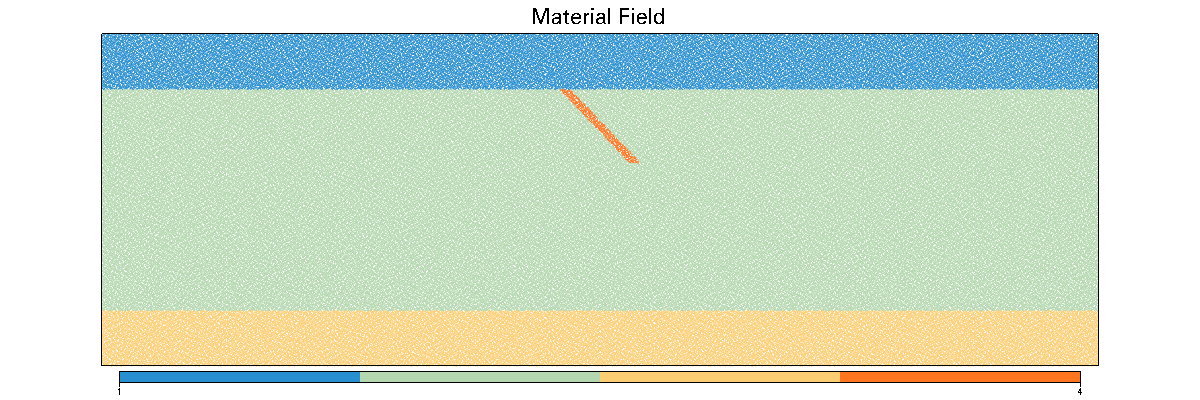

In [13]:
Fig = Model.plot.material(onMesh=False, figsize=(1200,400), fn_size=2.)

In [41]:
import numpy as np

x = np.linspace(Model.minCoord[0], Model.maxCoord[0], 1000) * u.kilometer
y = 0. * u.kilometer

surface_tracers = Model.add_passive_tracers(vertices=[x,y])
moho_tracers = Model.add_passive_tracers(vertices=[x,y-60.*u.kilometer])

x = 100. * u.kilometer
y = np.linspace(Model.minCoord[1], Model.maxCoord[1], 1000) * u.kilometer
vertical_tracers1 = Model.add_passive_tracers(vertices=[x,y])


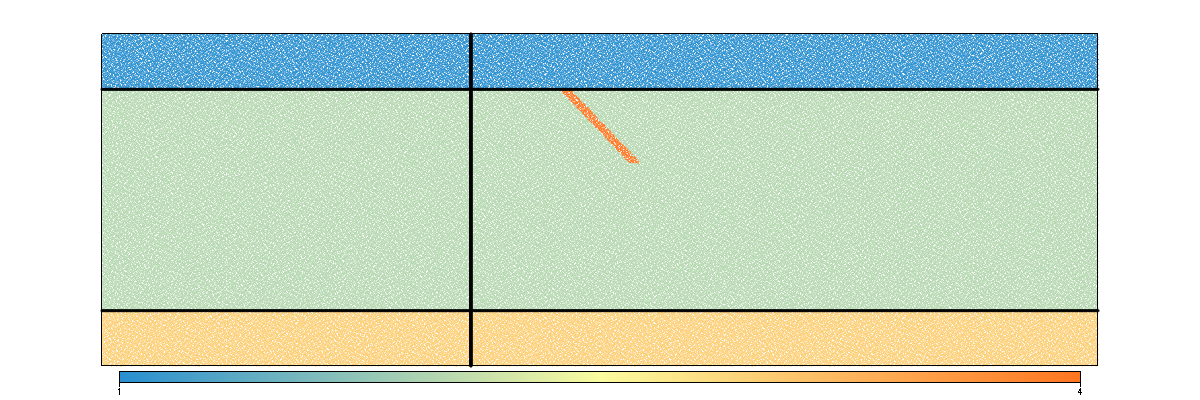

In [43]:
import glucifer
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(surface_tracers.swarm, pointSize=4.0)
Fig.Points(moho_tracers.swarm, pointSize=4.0)
Fig.Points(vertical_tracers1.swarm, pointSize=4.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

# Define Viscosities

The crust and the mantle have a visco-plastic rheology with a
temperature and stress dependent viscosity for stresses below the yield stress,
and a depth dependent plastic branch above it.
We use power law relationships between strain rate and stress
to describe dislocation creep. 

The viscosity varies with the temperature and stress according to:

crust, A, n and Q are those of quartz-rich rock (pre-exponent Ac=5·10−6 MPa−nc
s−1, nc=3, Qc=1.9·105 Jmol−1, Goetze,
1978). The pre-exponent factor for the fault is 10 · Ac which makes the fault ten times less viscous than the crust in which it is embedded. The rheology of the mantle is that of dry olivine (pre-exponent Am= 7·104 MPa−nc
s−1, nm=3, Qm=5.2·105 J mol−1, Brace and Kohlstedt,
1980). In

In [44]:
rh = GEO.ViscousCreepRegistry()

In [45]:
air.viscosity = 5e18 * u.pascal * u.second
continentalcrust.viscosity = rh.Goetze_et_al_1978
uppermantle.viscosity = rh.Brace_and_Kohlstedt_1980
fault.viscosity = 0.1 * rh.Goetze_et_al_1978

In [46]:
continentalcrust

In [47]:
uppermantle

In [48]:
fault

In the crust and the mantle, frictional sliding is modeled via a Mohr
Coulomb criterion with a cohesion (C0) of 15 MPa and a coefficient of friction (µ) of 0.44. 
The cohesion and coefficient of internal friction in the detachment fault are C0/10 and µ/10, respectively.
In all material, the yield stress linearly drops to a maximum of 20% of its initial value when the accumulated strain reaches 0.5 (cf.Wijns et al., 2005 for details). For differential stresses reaching the yield stress, the material fails and deformation is modeled by an effective viscosity: ηyield=τyield/(2 · E) in which E is the second invariant of the strain rate tensor. For semi-brittle effects, we impose a maximum yield stress of 250 MPa for the crust, 400MPa for the mantle and 10 MPa for the fault.

In [49]:
continentalcrust.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.044,
                                                epsilon1=0.5, epsilon2=1.0)

uppermantle.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                           cohesion=15. * u.megapascal,
                                           cohesionAfterSoftening=3. * u.megapascal,
                                           frictionCoefficient=0.44,
                                           frictionAfterSoftening=0.044,
                                           epsilon1=0.5, epsilon2=1.0)

fault.plasticity = GEO.DruckerPrager(name="Fault", 
                                     cohesion=1.5 * u.megapascal,
                                     cohesionAfterSoftening=0.3 * u.megapascal,
                                     frictionCoefficient=0.44,
                                     frictionAfterSoftening=0.044,
                                     epsilon1=0.5, epsilon2=1.0)

## Temperature Boundary Condition
The geotherm is based on a constant heat flow imposed at the base of the model (0.022 W m−2), a constant temperature imposed at the top (20 °C).

In [50]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=0.022 * u.watt)

## Velocity Boundary Conditions

In [51]:
Model.set_velocityBCs(left=[-25.5 * u.millimeter / u.year, None],
                       right=[25.5 * u.millimeter / u.year, None],
                       bottom=[None,0.])

## Run Model

In [52]:
Model.init_model()


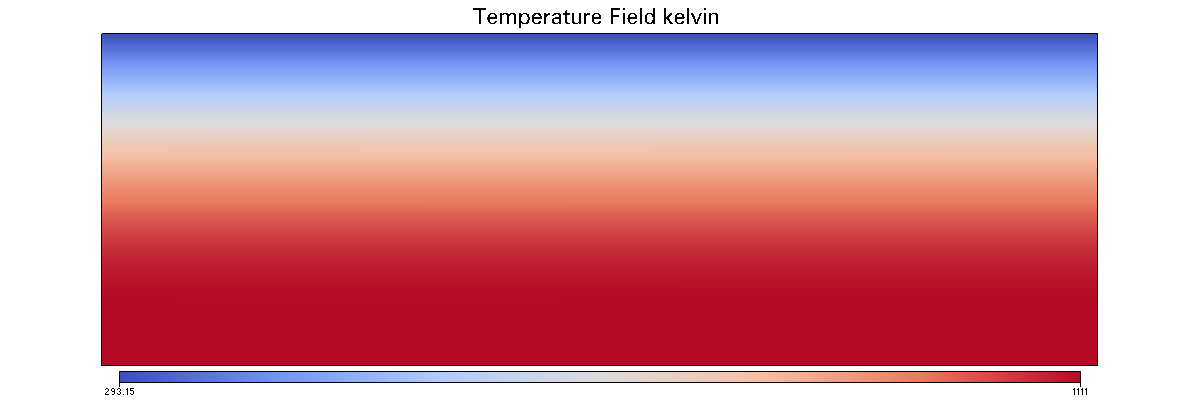

In [53]:
Fig = Model.plot.temperature(figsize=(1200,400), units=u.degK)


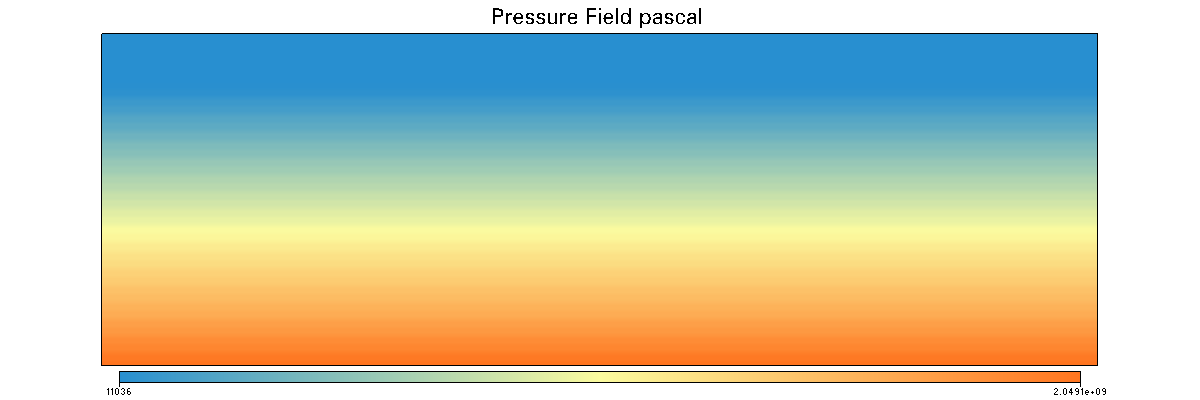

In [54]:
Fig = Model.plot.pressureField(figsize=(1200,400))

# Extract information using passive tracers

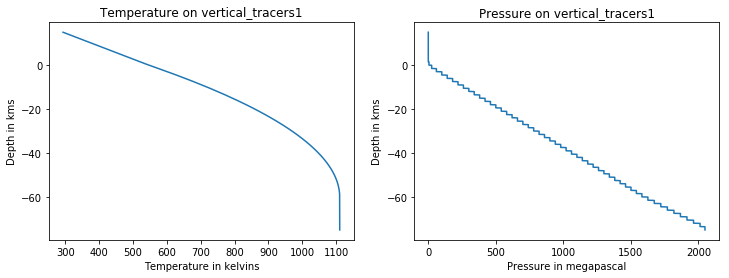

In [55]:
import pylab as plt

depths = vertical_tracers1.swarm.particleCoordinates.data[:,1] * GEO.Dimensionalize(1.0, u.kilometer)

# Extract Temperature
temp = Model.temperature.evaluate(vertical_tracers1.swarm) * GEO.Dimensionalize(1.0, u.degK)

# Extract Pressure
pressure = Model.pressureField.evaluate(vertical_tracers1.swarm) * GEO.Dimensionalize(1.0, u.megapascal) 

Fig, axes = plt.subplots(1,2,figsize=(12,4))
ax1, ax2 = axes
ax1.plot(temp, depths)
ax1.set_xlabel("Temperature in kelvins")
ax1.set_ylabel("Depth in kms")
ax1.set_title("Temperature on vertical_tracers1")

ax2.plot(pressure, depths)
ax2.set_xlabel("Pressure in megapascal")
ax2.set_ylabel("Depth in kms")
ax2.set_title("Pressure on vertical_tracers1")

plt.show()


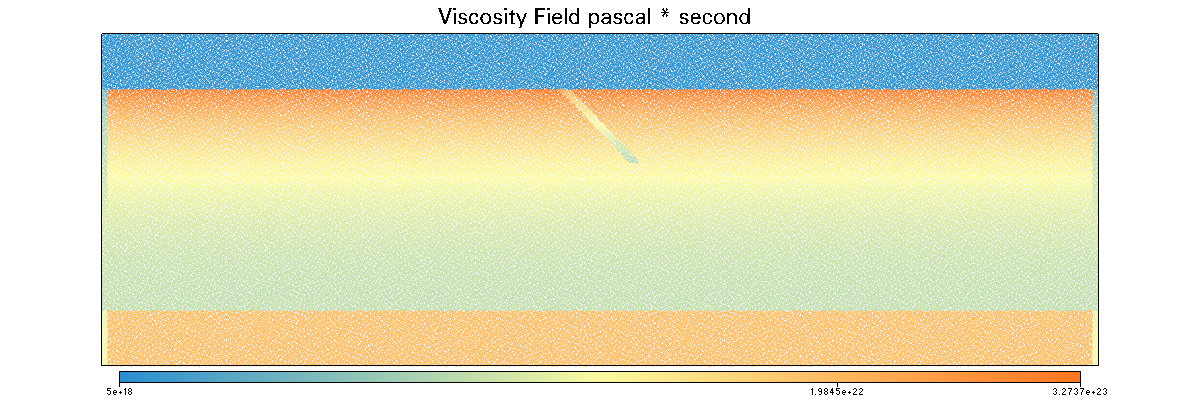

In [56]:
Fig = Model.plot.viscosity(figsize=(1200,400), fn_size=2.)

In [ ]:
GEO.rcParams["solver"] = "mumps"
GEO.rcParams["penalty"] = 1e6

In [ ]:
Model.run_for(5.* u.megayears, checkpoint_interval=100000. * u.year)

Time:  0.0116543024967 megayear dt: 0.0116543024967 megayear
Time:  0.0238009710494 megayear dt: 0.0121466685527 megayear
Time:  0.035948838663 megayear dt: 0.0121478676136 megayear
Time:  0.0480965677839 megayear dt: 0.0121477291209 megayear
Time:  0.0602438449573 megayear dt: 0.0121472771734 megayear
Time:  0.0723928146066 megayear dt: 0.0121489696493 megayear
Time:  0.0845423184006 megayear dt: 0.012149503794 megayear
Time:  0.0966853732054 megayear dt: 0.0121430548048 megayear
Time:  0.1 megayear dt: 0.00331462679461 megayear
Time:  0.112146935198 megayear dt: 0.0121469351985 megayear
Time:  0.124294444285 megayear dt: 0.0121475090866 megayear
Time:  0.136440589294 megayear dt: 0.0121461450094 megayear
Time:  0.148588279084 megayear dt: 0.0121476897895 megayear
Time:  0.160735920396 megayear dt: 0.0121476413123 megayear
Time:  0.172884265787 megayear dt: 0.0121483453912 megayear
Time:  0.185037629077 megayear dt: 0.01215336329 megayear
Time:  0.19686132446 megayear dt: 0.0118236953

In [ ]:
Fig =  Model.plot.material(onMesh=False, figsize=(1200,400), fn_size=2.)

In [ ]:
Fig = Model.plot.viscosity(figsize=(1200,400), fn_size=2.)

In [ ]:
Fig = Model.plot.velocityField(figsize=(1200,400))

In [ ]:
Fig = Model.plot.temperature(figsize=(1200,400))

In [ ]:
Fig = Model.plot.pressureField(figsize=(1200,400))

In [ ]:
Fig = Model.plot.strainRate(figsize=(1200,400))